In [194]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Add, Concatenate, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from itertools import cycle
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# New section

In [195]:
#   Paths to your dataset
train_loc = './train'
# val_loc = './test'
test_loc = './test'

In [196]:
# Data preparation
BATCH_SIZE = 32


In [197]:
trdata = ImageDataGenerator(rescale=1./255)

# Add error handling for the file not found case
try:
    train_data = trdata.flow_from_directory(directory=train_loc, target_size=(224,224), batch_size=BATCH_SIZE, shuffle=True, seed=42)
except FileNotFoundError:
    print(f"Error: Directory not found - {train_loc}")
    # Handle the error, e.g., by asking the user to verify the path or creating the directory

Found 4388 images belonging to 3 classes.


In [198]:
train_loc = './train'
val_loc = './test'

trdata = ImageDataGenerator(rescale=1./255)

# Add error handling for the file not found case
try:
    train_data = trdata.flow_from_directory(directory=train_loc, target_size=(224,224), batch_size=BATCH_SIZE, shuffle=True, seed=42)
except FileNotFoundError:
    print(f"Error: Directory not found - {train_loc}")
    # Handle the error, e.g., by asking the user to verify the path or creating the directory

Found 4388 images belonging to 3 classes.


In [199]:
# Class weights calculation for handling class imbalance
counter = Counter('./test')
max_val = float(max(counter.values()))
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}

In [200]:
# Function to build the VGG16-based model
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [201]:
# Function to build the VGG16-based model
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

In [202]:
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=conv_base.input, outputs=output_layer)
    return model

In [203]:
input_shape = (224, 224, 3)
n_classes = 2
optimizer = tf.keras.optimizers.Adam()
model = create_vgg16_model(input_shape, n_classes, optimizer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [204]:
model.summary()
# removed the indent from return model as it is not part of any function and was causing the error

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,109,186 (57.64 MB)

 Trainable params: 15,109,186 (57.64 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
input_shape = (224, 224, 3)
# opt = Adam(learning_rate=0.00001)
opt = Adam()
n_classes = len(train_data.class_indices)

In [206]:
n_classes

3

In [207]:
# Create the VGG16 model
model = create_vgg16_model(input_shape, n_classes, opt)


In [208]:
# Model saving and early stopping configuration
checkpoint = ModelCheckpoint("./vgg16_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

In [209]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assign the path to your validation data directory to the variable
validation_data_dir = './test'

# Set your desired values for image width and height
img_width = 224
img_height = 224

# Set the batch size
batch_size = 32 # Example value, adjust as needed

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    # You can add data augmentation options here if needed, like:
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

val_data = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 546 images belonging to 3 classes.


In [212]:
# Train the model
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_TEST = test_data.n // test_data.batch_size

In [213]:
dataset_folder_path = './test'


# Check if the folder exists and list its contents
import os
if os.path.exists(dataset_folder_path):
    print(f"Contents of {dataset_folder_path}:")
    print(os.listdir(dataset_folder_path))
else:
    print(f"Folder {dataset_folder_path} does not exist.")


Contents of ./test:
['.DS_Store', 'malignant', 'benign', 'normal']


In [214]:
import os

train_data_dir = './test'
# Check if the directory exists
if os.path.exists(train_data_dir):
    print(f"Directory exists: {train_data_dir}")
    print("Contents:", os.listdir(train_data_dir))  # List the contents of the directory
else:
    print(f"Directory not found: {train_data_dir}")


Directory exists: ./test
Contents: ['.DS_Store', 'malignant', 'benign', 'normal']


In [215]:
train_data_dir = './train'


In [216]:
import os

train_data_dir = './train'


# Check if the directory exists
if os.path.exists(train_data_dir):
    print(f"Directory exists: {train_data_dir}")
    print("Contents:", os.listdir(train_data_dir))  # List the contents of the directory
else:
    print(f"Directory not found: {train_data_dir}")


Directory exists: ./train
Contents: ['.DS_Store', 'malignant', 'benign', 'normal']


In [217]:
train_data_dir = './train'

In [218]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance
# You can customize the augmentation parameters as needed
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Example preprocessing - normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True # removed extra indent
)

# Load the training data
train_data = train_datagen.flow_from_directory(
    './train',
    target_size=(224, 224) # Moved target_size to flow_from_directory
)

Found 4388 images belonging to 3 classes.


In [219]:
# Import the required module
from tensorflow.keras.optimizers import Adam

# Define the optimizer
opt = Adam()

# Create the VGG16 model
model = create_vgg16_model(input_shape, n_classes, opt)

In [220]:
# Model saving and early stopping configuration
checkpoint = ModelCheckpoint("./vgg16_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)


In [221]:
# Train the model
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_TEST = test_data.n // test_data.batch_size

In [222]:
# Define a checkpoint directory
checkpoint_dir = './checkpoints_tf'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(optimizer=opt, model=model)

# Define a checkpoint manager to manage multiple checkpoints
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, checkpoint_dir, max_to_keep=5  # Keep last 5 checkpoints
)


# First Time use following line of code
### No need after code break

In [223]:
from tensorflow.keras.callbacks import Callback

In [224]:
# Define a custom callback to save checkpoints
class CustomCheckpointCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        checkpoint_manager.save()
        print(f"\nCheckpoint saved at epoch {epoch + 1}")



In [225]:
# Define the same model structure again
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # Flatten the 28x28 image
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load the saved weights
#model.load_weights("/content/checkpoint.pth")

# Load the MNIST dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (example)
train_data = train_data.reshape((60000, 28, 28, 1))
test_data = test_data.reshape((10000, 28, 28, 1))
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Continue training
model.fit(train_data, train_labels, initial_epoch=0, epochs=10, validation_data=(test_data, test_labels))

/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8685 - loss: 0.4734 - val_accuracy: 0.9518 - val_loss: 0.1704
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9548 - loss: 0.1559 - val_accuracy: 0.9619 - val_loss: 0.1272
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9687 - loss: 0.1064 - val_accuracy: 0.9681 - val_loss: 0.1025
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9746 - loss: 0.0816 - val_accuracy: 0.9718 - val_loss: 0.0889
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9812 - loss: 0.0631 - val_accuracy: 0.9724 - val_loss: 0.0879
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9825 - loss: 0.0551 - val_accuracy: 0.9732 - val_loss: 0.0866
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9872 - loss: 0.0433 - val_accuracy: 0.9740 - val_loss: 0.0844
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9887 - loss: 0.0371 - 

# Break the check points

In [226]:
# Compile the model
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy
              metrics=['accuracy'])

In [238]:
# Define the same model structure again
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # Flatten the 28x28 image
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load the MNIST dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (example)
train_data = train_data.reshape((60000, 28, 28, 1))
test_data = test_data.reshape((10000, 28, 28, 1))
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Continue training
history = model.fit(
    train_data,
    train_labels,
    epochs=10,
    initial_epoch=0,
    validation_data=(test_data, test_labels),
    callbacks=[CustomCheckpointCallback(), early_stop]
)

/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1838/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8611 - loss: 0.4922
Checkpoint saved at epoch 1
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8622 - loss: 0.4882 - val_accuracy: 0.9503 - val_loss: 0.1688
Epoch 2/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9551 - loss: 0.1540
Checkpoint saved at epoch 2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9551 - loss: 0.1539 - val_accuracy: 0.9650 - val_loss: 0.1177
Epoch 3/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9692 - loss: 0.1067
Checkpoint saved at epoch 3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9692 - loss: 0.1066 - val_accuracy: 0.9715 - val_loss: 0.0968
Epoch 4/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9755 - loss: 0.0810
Checkpoint saved at epoch 4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9755 - loss: 0.0810 - val_accuracy: 0.9737 - val_loss: 0.0918
Epoch 5/10
1835/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accu

In [239]:
# Reshape test_data to match the input shape of the model
# test_data = test_data.reshape((-1, 28, 28, 1))

# Evaluate on test data
STEP_SIZE_TEST = len(test_labels) // batch_size
test_loss, test_acc = model.evaluate(test_data[:len(test_labels)], test_labels, steps=STEP_SIZE_TEST)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.9747 - loss: 0.0931
Test Loss: 0.08103528618812561
Test Accuracy: 0.9779000282287598


2024-10-16 11:28:16.276509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/hassanazhar/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [229]:
# Calculate the correct step size
STEP_SIZE_TEST = test_data.shape[0] // batch_size
if test_data.shape[0] % batch_size != 0:
    STEP_SIZE_TEST += 1

In [240]:
# Make predictions on the test data
predictions = model.predict(test_data, steps=STEP_SIZE_TEST)
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes.size

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


2024-10-16 11:28:21.336421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10000

In [241]:
test_data = test_data.reshape((-1, 28, 28, 1))
STEP_SIZE_TEST = len(test_labels) // batch_size
test_loss, test_acc = model.evaluate(test_data[:len(test_labels)], test_labels, steps=STEP_SIZE_TEST)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9747 - loss: 0.0931
Test Loss: 0.08103528618812561
Test Accuracy: 0.9779000282287598


2024-10-16 11:28:27.279836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [242]:
len(true_classes)

546

In [246]:
import numpy as np
from scipy.special import softmax

predictions_3_classes = predictions[:, :3]

# Apply softmax to the first 3 classes to scale them to probabilities
scaled_predictions = softmax(predictions_3_classes, axis=1)

# Print scaled predictions
print(scaled_predictions)

# Convert probabilities to class indices (choosing the highest probability class)
predicted_classes = np.argmax(scaled_predictions, axis=1)

# Example true labels for testing purposes
y_test = np.array([0, 1, 2])

# Generate the classification report for 3 classes
from sklearn.metrics import classification_report
class_names = ['benign', 'malignant', 'normal']
report = classification_report(true_classes, predicted_classes[:len(true_classes)], target_names=class_names)

print(report)


[[0.3333323  0.3333323  0.33333546]
 [0.21194169 0.21194182 0.5761165 ]
 [0.21219428 0.5756088  0.21219692]
 ...
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]
              precision    recall  f1-score   support

      benign       0.45      0.47      0.46       233
   malignant       0.23      0.25      0.24       121
      normal       0.39      0.35      0.37       192

    accuracy                           0.38       546
   macro avg       0.36      0.36      0.36       546
weighted avg       0.38      0.38      0.38       546



In [244]:
test_data = datagen.flow_from_directory(
    test_data_dir,  # Change to 'train_data_dir' if you want to test on training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to avoid shuffling for correct evaluation
)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
report = classification_report(true_classes, predicted_classes[:len(true_classes)], target_names=class_labels)

Found 546 images belonging to 3 classes.


ValueError: Number of classes, 10, does not match size of target_names, 3. Try specifying the labels parameter

In [235]:
print(report)

              precision    recall  f1-score   support

      benign       0.45      0.20      0.27       233
   malignant       0.23      0.33      0.27       121
      normal       0.38      0.54      0.45       192

    accuracy                           0.35       546
   macro avg       0.35      0.35      0.33       546
weighted avg       0.38      0.35      0.33       546



In [44]:
STEP_SIZE_TEST = test_data.shape[0] // batch_size
if test_data.shape[0] % batch_size != 0:
    STEP_SIZE_TEST += 1

In [45]:
predictions = model.predict(test_data, steps=STEP_SIZE_TEST)
predicted_classes = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


In [35]:
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [36]:
def predict_image_class(img_path):
    img = prepare_image(img_path)
    print(f"Shape of preprocessed image: {img.shape}")
    prediction = model.predict([img], steps=STEP_SIZE_TEST)
    class_names = ['Benign', 'Malignant', 'Normal']
    predicted_class = class_names[np.argmax(prediction)]
    img_display = image.load_img(img_path)
    plt.imshow(img_display)
    plt.title(f'Predicted: {predicted_class}')
    plt.show()
    return predicted_class

In [41]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [42]:
test_image_path = './test/benign/benign (306).png'

Shape of preprocessed image: (1, 224, 224, 3)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step   


2024-10-16 10:39:52.923091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


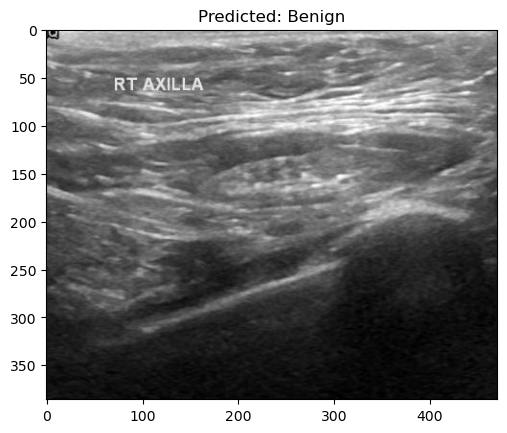

In [43]:
predicted_class = predict_image_class(test_image_path)

In [44]:
print(f'The predicted class is: {predicted_class}')

The predicted class is: Benign


In [47]:
import os
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


# Set the directory path for testing data
test_data_dir = './test'  # You can change this to training if needed

# Set your desired values for image width, height, and batch size
img_width, img_height = 224, 224
batch_size = 32

# Create an ImageDataGenerator for the test data
datagen = ImageDataGenerator(rescale=1./255)  # Rescale as in training

# Load the validation data
test_data = datagen.flow_from_directory(
    test_data_dir,  # Change to 'train_data_dir' if you want to test on training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to avoid shuffling for correct evaluation
)

# Make predictions using the loaded model
predictions = model.predict(test_data, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

Found 235 images belonging to 3 classes.


/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/stepWARNING:tensorflow:5 out of the last 322 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x17c91cb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step


In [185]:
# Get the true labels
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  # Get class labels

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

AttributeError: 'numpy.ndarray' object has no attribute 'classes'

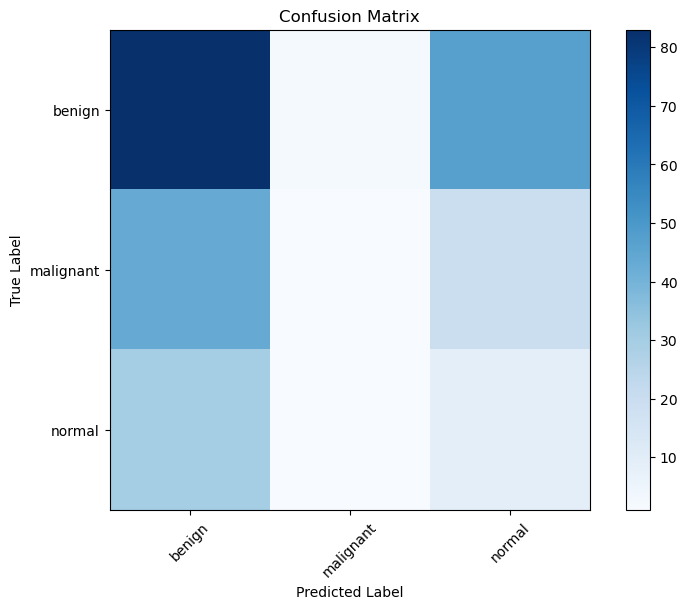

In [49]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [50]:
import seaborn as sns  # Import Seaborn for advanced plotting
import matplotlib.pyplot as plt  # Import Matplotlib for basic plotting

# Assuming you have already calculated the confusion matrix `cm` and `true_classes` and `predicted_classes`


In [51]:
# Define the class labels
# class_labels = [str(i) for i in range(10)] # Assuming 10 classes, modify if necessary
class_labels = list(test_data.class_indices.keys())  # Get class labels

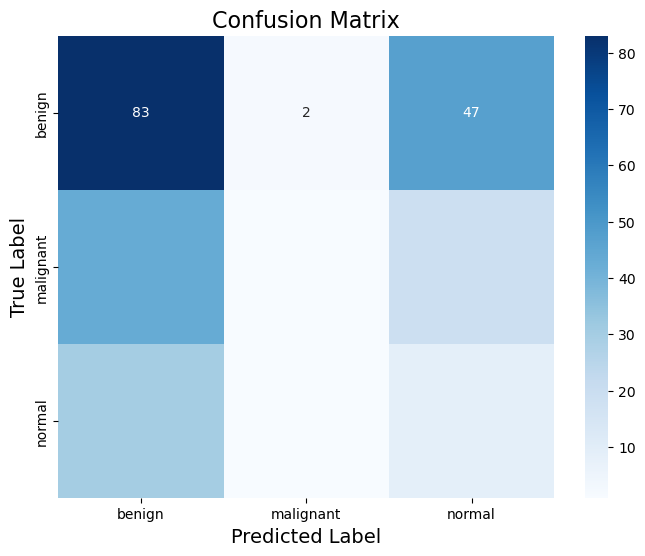

In [52]:
# Import the necessary library
from sklearn.metrics import confusion_matrix

# Assuming you have true_classes and predicted_classes defined
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


# **1. SVM Classifier**


In [4]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reshape train_data and test_data
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

# Scale the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# SVM classifier
svm_clf = svm.SVC(kernel='linear', probability=True)
svm_clf.fit(train_data, train_labels)

# Predict using SVM
svm_pred = svm_clf.predict(test_data)

# Classification report
print("SVM Classification Report:")
print(classification_report(test_labels, svm_pred))

# Confusion Matrix
svm_cm = confusion_matrix(test_labels, svm_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

NameError: name 'train_data' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize # Removed extra indentation

# Binarize the labels for multiclass ROC AUC calculation
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(n_classes):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], svm_prob[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot the ROC curves (example for one class)
plt.figure()
plt.plot(fpr_svm[0], tpr_svm[0], label='ROC curve (area = %0.2f)' % roc_auc_svm[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# **2. K-Nearest Neighbors (KNN) Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5) # You can change n_neighbors based on your data
knn_clf.fit(train_data, train_labels)

# Predict using KNN
knn_pred = knn_clf.predict(test_data)

# Classification report
print("KNN Classification Report:")
print(classification_report(test_labels, knn_pred))

# Confusion Matrix
knn_cm = confusion_matrix(test_labels, knn_pred)

# Plotting the confusion matrix for KNN
plt.figure(figsize=(8,6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# ROC CURVE


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multiclass ROC AUC calculation
test_labels_bin = label_binarize(test_labels, classes=np.unique(test_labels))

# Calculate ROC curve and AUC for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
n_classes = test_labels_bin.shape[1]

for i in range(n_classes):
    knn_prob_class_i = knn_clf.predict_proba(test_data)[:, i]  # Probability for class i
    fpr_knn[i], tpr_knn[i], _ = roc_curve(test_labels_bin[:, i], knn_prob_class_i)
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Plot ROC curves for each class (example for one class)
# Replace plot_roc_curve with your actual plotting function
# plot_roc_curve(fpr_knn[0], tpr_knn[0], roc_auc_knn[0], 'KNN - Class 0')

# ... (Similarly plot for other classes) ...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# ... (your existing code from ipython-input-55-a1d1401d8c5a) ...

# Function to plot ROC curve (modified)
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    """
    Plots the ROC curve for a given model.

    Args:
        fpr (dict): False positive rates for each class.
        tpr (dict): True positive rates for each class.
        roc_auc (dict): AUC values for each class.
        model_name (str): Name of the model for the plot title.
    """

    n_classes = len(fpr) # Get number of classes

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i])
        display.plot(ax=plt.gca(), name=f'{model_name} - Class {i}') # Plot on current axes

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


# Call the function with the calculated values
plot_roc_curve(fpr_knn, tpr_knn, roc_auc_knn, 'KNN')

# **3. Naive Bayes Classifier:**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(train_data, train_labels)

# Predict using Naive Bayes
nb_pred = nb_clf.predict(test_data)

# Classification report
print("Naive Bayes Classification Report:")
print(classification_report(test_labels, nb_pred))

# Confusion Matrix
nb_cm = confusion_matrix(test_labels, nb_pred)

# Plotting the confusion matrix for Naive Bayes
plt.figure(figsize=(8,6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Calculate accuracy scores for each classifier
svm_acc = accuracy_score(test_labels, svm_pred)
knn_acc = accuracy_score(test_labels, knn_pred)
nb_acc = accuracy_score(test_labels, nb_pred)

# Accuracy comparison plot
classifiers = ['SVM', 'KNN', 'Naive Bayes']
accuracies = [svm_acc, knn_acc, nb_acc]

plt.figure(figsize=(8,6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of SVM, KNN, and Naive Bayes')
plt.show()


# ROC CURVE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.naive_bayes import GaussianNB

# Assuming train_data, train_labels, test_data, and test_labels are already defined

# Reshape train_data and test_data before fitting and predicting
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

# Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(train_data, train_labels)

# Predict probabilities
nb_prob = nb_clf.predict_proba(test_data)

# Binarize the labels for multiclass ROC AUC calculation
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_test_bin[:, i], nb_prob[:, i])
    roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# ... (your existing code from ipython-input-55-a1d1401d8c5a) ...

# Function to plot ROC curve (modified)
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    """
    Plots the ROC curve for a given model.

    Args:
        fpr (dict or array-like): False positive rates for each class or a single class.
        tpr (dict or array-like): True positive rates for each class or a single class.
        roc_auc (dict or float): AUC values for each class or a single class.
        model_name (str): Name of the model for the plot title.
    """

    # Check if fpr is a dictionary (multi-class) or not (single-class)
    if isinstance(fpr, dict):
        n_classes = len(fpr)
        # Plot ROC curves for each class (multi-class case)
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i])
            display.plot(ax=plt.gca(), name=f'{model_name} - Class {i}')
    else:
        # Plot ROC curve for a single class (single-class case)
        plt.figure(figsize=(8, 6))
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot(ax=plt.gca(), name=model_name)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call the function with the calculated values
plot_roc_curve(fpr_nb, tpr_nb, roc_auc_nb, 'Naive Bayes - Class 0')

# COMPARISON

In [ ]:
# Plot ROC curves for all classifiers
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'SVM')
plot_roc_curve(fpr_knn, tpr_knn, roc_auc_knn, 'KNN')
plot_roc_curve(fpr_nb, tpr_nb, roc_auc_nb, 'Naive Bayes')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM, KNN, and Naive Bayes')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Calculate accuracy scores for each classifier
svm_acc = accuracy_score(test_labels, svm_pred)
knn_acc = accuracy_score(test_labels, knn_pred)
nb_acc = accuracy_score(test_labels, nb_pred)

# Accuracy comparison plot
classifiers = ['SVM', 'KNN', 'Naive Bayes']
accuracies = [svm_acc, knn_acc, nb_acc]

plt.figure(figsize=(8,6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of SVM, KNN, and Naive Bayes')
plt.show()


## Testing the Trained Model

In [ ]:
import os
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/MyDrive/saved_models/vgg16_model.keras'
model = load_model(model_path)

# Set the directory path for testing data
test_data_dir = '/content/drive/MyDrive/Training augmented/Validation'  # You can change this to training if needed

# Set your desired values for image width, height, and batch size
img_width, img_height = 224, 224
batch_size = 32

# Create an ImageDataGenerator for the test data
datagen = ImageDataGenerator(rescale=1./255)  # Rescale as in training

# Load the validation data
test_data = datagen.flow_from_directory(
    test_data_dir,  # Change to 'train_data_dir' if you want to test on training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to avoid shuffling for correct evaluation
)

# Make predictions using the loaded model
predictions = model.predict(test_data, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

### Evaluation

In [ ]:
# Get the true labels
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  # Get class labels

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)


### Plotting confusion matrix

In [ ]:

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
